# Types of Agent Architectures

1. Single Multi-agent (Sequential flow)

2. Supervisor Multi-agent (Orchestrator based - supervisor delegates the tasks)
3. Hierarchial Architecture

## 1. Single Multi-agent Architecture

Researcher and Writer Agents

### Importing required libraries

In [30]:
import os
from typing import TypedDict, Annotated, List, Literal

# For LangChain
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

# For LangGraph
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

### Initializing Groq LLM

In [31]:
from dotenv import load_dotenv
load_dotenv()

llm = ChatGroq(model="llama-3.1-8b-instant")

llm.invoke("Hello")

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.013948733, 'prompt_time': 0.002047686, 'queue_time': 0.048964604, 'total_time': 0.015996419}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_0f5c9bc037', 'finish_reason': 'stop', 'logprobs': None}, id='run--01456a69-5cfe-4277-9ea6-c3b0928b8e09-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

### Creating State

In [48]:
def AgentState(MessagesState):
    next_agent: str # The next agent to invoke

### Creating TavilySearch Tool for `Researcher Agent`

In [49]:
@tool
def search_web(query: str) -> str:
    """ Search the web for latest information.  """
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)

    return str(results)

### Creating WriteSummary Tool for `Content Writer Agent`

In [50]:
@tool
def write_summary(content: str) -> str: 
    """ Write a summary of the provided content. """

    summary = f"Summary of findings:\n\n{content[:500]}"
    return summary

### Defining `Researcher Agent` Node

In [51]:
def researcher_agent(agentState: AgentState): 

    # fetching the messages from agentState
    messages = agentState["messages"]

    # creating the system message for the agent
    system_message = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")

    # Binding tavily search tool with the llm
    llm_with_tool = llm.bind_tools([search_web])

    # Invoking the LLM with the system message and user messages
    response = llm_with_tool.invoke([system_message] + messages)

    # Returning the response and routing to the next agent i.e., Content Writer
    return {
        "messages": [response],
        "next_agent": "writer"
    }

### Defining `Writer Agent` Node

In [52]:
def writer_agent(agentState: AgentState): 

    # fetching the messages from agentState
    messages = agentState["messages"]

    # creating the system message for the agent
    system_message = SystemMessage(content="You are a technical writer. Use the write_summary tool, review the conversation and create a clear, concise summary of the findings.")

    # Binding tavily search tool with the llm
    llm_with_tool = llm.bind_tools([write_summary])

    # Invoking the LLM with the system message and user messages
    response = llm_with_tool.invoke([system_message] + messages)

    # Returning the response and routing to the next agent i.e., Content Writer
    return {
        "messages": [response],
        "next_agent": "end"
    }

### Creating Tool Executor Node

In [53]:
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""
    
    messages = state["messages"] # Fetching messages from the state

    last_message = messages[-1] # Taking the last message to check for tool calls
    
    # Check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state

### Creating Multi-Agent Graph

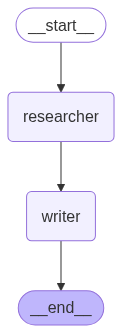

In [54]:
# Building the state graph
workflow = StateGraph(MessagesState)

# Add Nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Add Edges
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)

# Compiling the graph
final_workflow = workflow.compile()

final_workflow

### Executing the Graph

In [55]:
response=final_workflow.invoke({"messages":"Research about the usecase of agentic ai in business"})

In [56]:
response["messages"][-1].content

''